<a href="https://colab.research.google.com/github/GiulioAppetito/CodiceFiscale/blob/master/task1_centralizzato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU, PReLU
import numpy as np
from keras.initializers import RandomNormal, he_normal, glorot_normal, he_uniform, glorot_uniform
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from keras.metrics import Precision, Recall, F1Score, Accuracy

In [ ]:
# Inizializza il seed per NumPy per riproducibilità
np.random.seed(42)

# Inizializza il seed per TensorFlow per riproducibilità
tf.random.set_seed(42)

# Caricamento del dataframe
df_train = pd.read_csv('/content/drive/MyDrive/customer_churn_dataset-training-master.csv')
df_test = pd.read_csv('/content/drive/MyDrive/customer_churn_dataset-testing-master.csv')
df = pd.concat([df_train, df_test])
df.info()

# Binning age
bins=[18,25,35,50,60,70,100]
df['Age_binned'] = pd.cut(df['Age'], bins)
df = df.drop(['Age','CustomerID'],axis=1)
df

import seaborn as sns
import matplotlib.pyplot as plt

# Calcola la matrice di correlazione
correlation_matrix = df.corr()

# Crea una heatmap della matrice di correlazione
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice di Correlazione')
plt.show()

# Define categorical and numerical features
numeric_features = ['Tenure','Support Calls','Payment Delay','Usage Frequency','Total Spend',	'Last Interaction']
categorical_features = ['Age_binned','Contract Length','Gender',	'Subscription Type']

# Divide dataset in features (X) and target (y)
X = df.drop(columns=['Churn'])
y = df['Churn']

# Encoding target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Divide dataset in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Gestione dei dati mancanti
    ('scaler', StandardScaler()),  # Normalizzazione delle feature numeriche
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder()),  # Encoding delle variabili categoriche
    ('imputer', SimpleImputer(strategy='most_frequent'))  # Gestione dei dati mancanti
])

# Define preprocessor for categorical and numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Processing of data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

import pandas as pd

# Ottieni l'elenco delle colonne numeriche dopo la trasformazione
numeric_features_transformed = preprocessor.named_transformers_['num'].named_steps['scaler'].get_feature_names_out(numeric_features)

# Ottieni l'elenco delle colonne categoriche dopo la trasformazione
categorical_features_transformed = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

# Unisci i due elenchi di colonne
feature_names = list(numeric_features_transformed) + list(categorical_features_transformed)

# Costruisci dataframe preprocessati per il set di addestramento
X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names)

# Costruisci dataframe preprocessati per il set di test
X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names)

# Ora X_train_processed_df e X_test_processed_df sono dataframe pandas preprocessati
X_train_processed_df

# Concatenazione delle feature preprocessate con le etichette per il training set
df_train_processed = pd.concat([X_train_processed_df, pd.DataFrame({'Churn': y_train})], axis=1)

# Concatenazione delle feature preprocessate con le etichette per il test set
df_test_processed = pd.concat([X_test_processed_df, pd.DataFrame({'Churn': y_test})], axis=1)

# Salva il training set preprocessato completo in un file CSV
df_train_processed.to_csv('/content/drive/MyDrive/train.csv', index=False)

# Salva il test set preprocessato completo in un file CSV
df_test_processed.to_csv('/content/drive/MyDrive/test.csv', index=False)


In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy', Precision(), Recall(), F1Score()])

  return model

In [4]:
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Precision, Recall, F1Score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_normal, glorot_normal
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from sklearn.model_selection import train_test_split

def model_builder(hp):
    model = Sequential()

    # Tune the number of units and activation function for each Dense layer
    for i in range(hp.Int('num_layers', 2, 5, default=4)):
        hp_units = hp.Int(f'units_{i}', min_value=16, max_value=128, step=16)
        hp_activation = hp.Choice(f'activation_{i}', values=['PReLU','LeakyReLU','relu', 'tanh', 'sigmoid'])

        model.add(Dense(units=hp_units, activation=hp_activation, kernel_initializer=he_normal))

    # Output layer
    model.add(Dense(1, activation='sigmoid', kernel_initializer=glorot_normal))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Tune the initializer for the Dense layers
    hp_initializer = hp.Choice('initializer', values=['he_normal', 'glorot_normal'])

    if hp_initializer == 'he_normal':
        initializer = he_normal()
    else:
        initializer = glorot_normal()

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', Precision(), Recall(), F1Score()])

    return model

# Assuming you have X_train_processed, y_train, X_test_processed, and y_test defined

# Convert class labels to float32
y_train = np.float32(y_train)
y_test = np.float32(y_test)

# Define the tuner and other components as you did before
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='multi_layer_tuning')

stop_early = EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train_processed, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of layers is {best_hps.get('num_layers')}.
""")

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_processed, y_train, epochs=30, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch:', best_epoch)

# Retrain the model
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(X_train_processed, y_train, epochs=10, validation_split=0.2)

# Evaluate the model on the test set
eval_result = hypermodel.evaluate(X_test_processed, y_test)


Trial 30 Complete [00h 05m 24s]
val_accuracy: 0.9326883554458618

Best val_accuracy So Far: 0.9339378476142883
Total elapsed time: 01h 03m 55s

The hyperparameter search is complete. The optimal number of layers is 3.

Epoch 1/30
10105/10105 [==============================] - 31s 3ms/step - loss: 0.2410 - accuracy: 0.9189 - precision_1: 0.8935 - recall_1: 0.9694 - f1_score: 0.7140 - val_loss: 0.2177 - val_accuracy: 0.9286 - val_precision_1: 0.9002 - val_recall_1: 0.9802 - val_f1_score: 0.7141
Epoch 2/30
10105/10105 [==============================] - 29s 3ms/step - loss: 0.2161 - accuracy: 0.9280 - precision_1: 0.8952 - recall_1: 0.9857 - f1_score: 0.7140 - val_loss: 0.2101 - val_accuracy: 0.9301 - val_precision_1: 0.8979 - val_recall_1: 0.9863 - val_f1_score: 0.7141
Epoch 3/30
10105/10105 [==============================] - 29s 3ms/step - loss: 0.2116 - accuracy: 0.9291 - precision_1: 0.8957 - recall_1: 0.9873 - f1_score: 0.7140 - val_loss: 0.2081 - val_accuracy: 0.9302 - val_precision_

In [5]:
print("[test loss, test accuracy, test precision, test recall, test F1score]:", eval_result)

[test loss, test accuracy, test precision, test recall, test F1score]: [0.2027428150177002, 0.9301082491874695, 0.8957387804985046, 0.9892116189002991, array([0.713832], dtype=float32)]


In [6]:
best_hps.values

{'num_layers': 3,
 'units_0': 32,
 'activation_0': 'relu',
 'units_1': 96,
 'activation_1': 'PReLU',
 'units_2': 128,
 'activation_2': 'tanh',
 'learning_rate': 0.001,
 'units_3': 96,
 'activation_3': 'sigmoid',
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0012',
 'units_4': 16,
 'activation_4': 'PReLU'}

In [7]:
hypermodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 32)                768       
                                                                 
 dense_11 (Dense)            (None, 96)                3264      
                                                                 
 dense_12 (Dense)            (None, 128)               12416     
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 16577 (64.75 KB)
Trainable params: 16577 (64.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1', 'val_f1_score'])

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

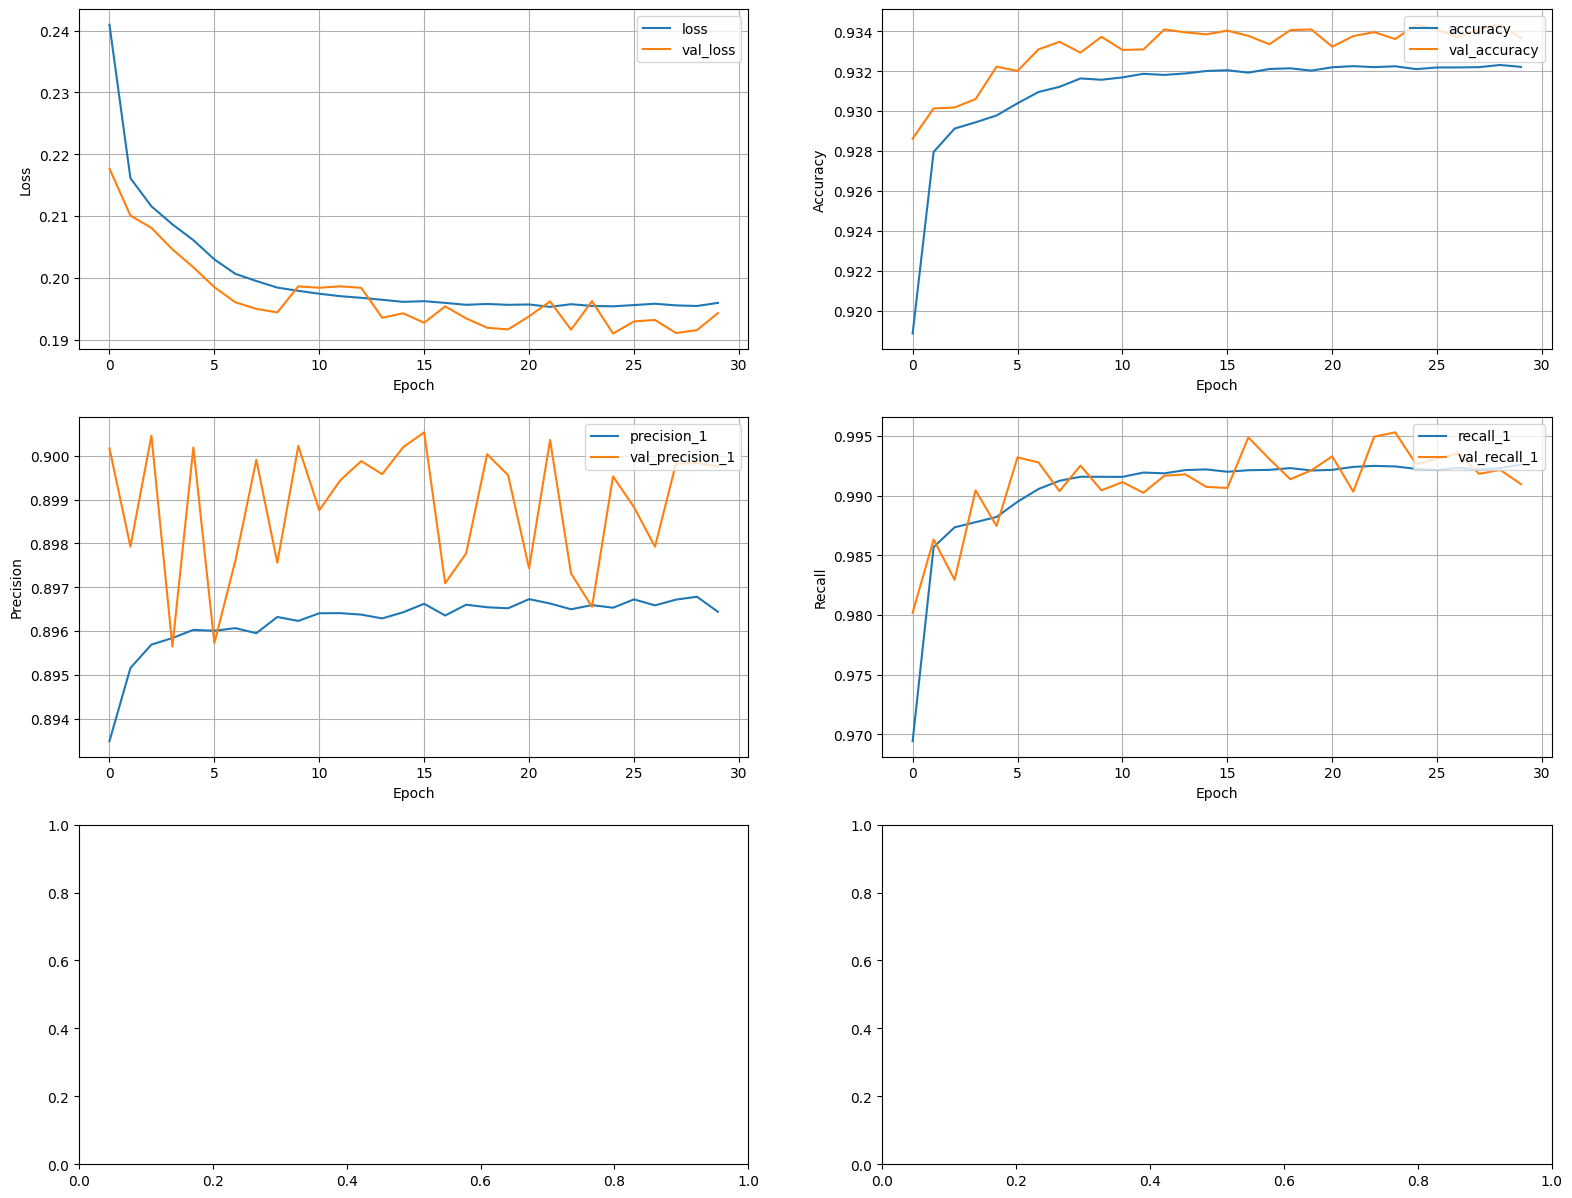

In [10]:
import matplotlib.pyplot as plt
from tabulate import tabulate

def plot_loss(history):
    fig, ((ax1, ax2), (ax3, ax4), ax5) = plt.subplots(3, 2, figsize=(19, 15))

    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set(xlabel='Epoch', ylabel='Loss')
    ax1.legend(loc="upper right")
    ax1.grid(True)

    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set(xlabel='Epoch', ylabel='Accuracy')
    ax2.legend(loc="upper right")
    ax2.grid(True)

    ax3.plot(history.history['precision_1'], label='precision_1')
    ax3.plot(history.history['val_precision_1'], label='val_precision_1')
    ax3.set(xlabel='Epoch', ylabel='Precision')
    ax3.legend(loc="upper right")
    ax3.grid(True)

    ax4.plot(history.history['recall_1'], label='recall_1')
    ax4.plot(history.history['val_recall_1'], label='val_recall_1')
    ax4.set(xlabel='Epoch', ylabel='Recall')
    ax4.legend(loc="upper right")
    ax4.grid(True)

    ax5.plot(history.history['f1_score'], label='f1_score')
    ax5.plot(history.history['val_f1_score'], label='val_f1_score')
    ax5.set(xlabel='Epoch', ylabel='F1 Score')
    ax5.legend(loc="upper right")
    ax5.grid(True)

    fig.tight_layout()

    # Tabella
    data_table = [
        ["Epoch", "Loss", "Accuracy", "Precision", "Recall", "F1 Score"],
    ]
    for epoch in range(len(history.history['loss'])):
        data_table.append([
            epoch+1,
            history.history['loss'][epoch],
            history.history['accuracy'][epoch],
            history.history['precision_1'][epoch],
            history.history['recall_1'][epoch],
            history.history['f1_score'][epoch]
        ])

    table = tabulate(data_table, headers="firstrow", tablefmt="fancy_grid")
    print(table)

plot_loss(history)

In [ ]:
hypermodel =